# Bilateral Filter Demo
This notebook demos a barebones Python implementation of a bilateral filter using a hard bilateral grid. This approach to bilateral filtering is fast, but produces low-quality output. The grid sizes are set differently from those in the bilateral_solver demo, as using the solver parameters has very little effect in the filter.

In [24]:
%pylab inline
import pylab
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'CMRmap'
rcParams['figure.facecolor'] = 'w'

Populating the interactive namespace from numpy and matplotlib


/home/bala/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['imread', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Load in the input problem

Text(0.5, 1.0, 'target')

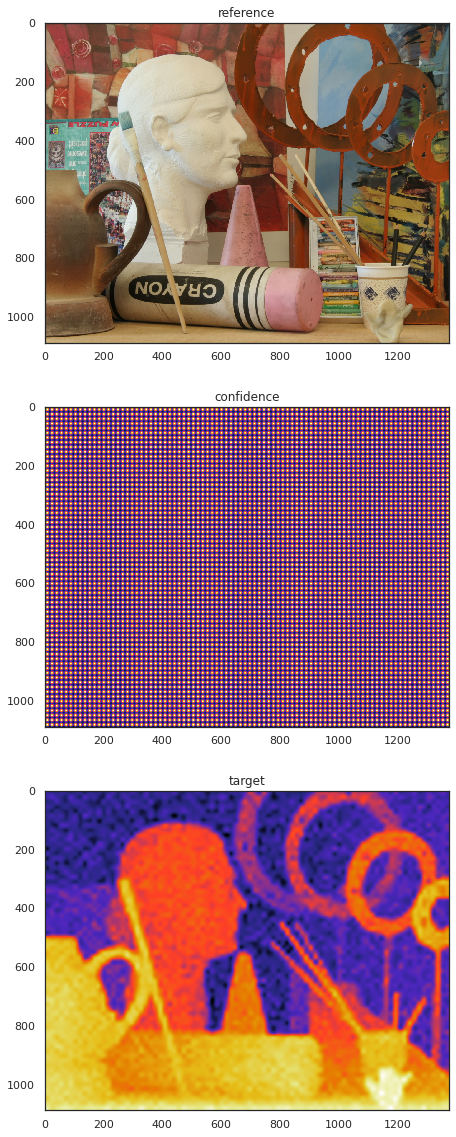

In [25]:
from skimage.io import imread
import os
data_folder = os.path.abspath(os.path.join(os.path.curdir, '../..', 'images', 'depth_superres'))
reference = imread(os.path.join(data_folder, 'reference.png'))
target = imread(os.path.join(data_folder, 'target.png'))
confidence = imread(os.path.join(data_folder, 'confidence.png'))
im_shape = reference.shape[:2]
assert(im_shape[0] == target.shape[0])
assert(im_shape[1] == target.shape[1])
assert(im_shape[0] == confidence.shape[0])
assert(im_shape[1] == confidence.shape[1])

figure(figsize=(14, 20))
subplot(311)
imshow(reference)
title('reference')
subplot(312)
imshow(confidence)
title('confidence')
subplot(313)
imshow(target)
title('target')

### RGB--YUV conversion
Actually doing RGB-YCbCr. Math from https://en.wikipedia.org/wiki/YCbCr#JPEG_conversion

In [26]:
# From: https://en.wikipedia.org/wiki/YCbCr#JPEG_conversion
RGB_TO_YUV = np.array([
    [ 0.299,     0.587,     0.114],
    [-0.168736, -0.331264,  0.5],
    [ 0.5,      -0.418688, -0.081312]])
YUV_TO_RGB = np.array([
    [1.0,  0.0,      1.402],
    [1.0, -0.34414, -0.71414],
    [1.0,  1.772,    0.0]])
YUV_OFFSET = np.array([0, 128.0, 128.0]).reshape(1, 1, -1)

def rgb2yuv(im):
    return (np.tensordot(im, RGB_TO_YUV, ([2], [1])) + YUV_OFFSET)

def yuv2rgb(im):
    return np.tensordot(im.astype(float) - YUV_OFFSET, YUV_TO_RGB, ([2], [1]))

## Bilateral grid
Implement the bilateral grid using a hacky hasing function to go from coordinates to unique numbers.

In [30]:
MAX_VAL = 255.0
from scipy.sparse import csr_matrix

def get_valid_idx(valid, candidates):
    """Find which values are present in a list and where they are located"""
    locs = np.searchsorted(valid, candidates)
    # Handle edge case where the candidate is larger than all valid values
    locs = np.clip(locs, 0, len(valid) - 1)
    # Identify which values are actually present
    valid_idx = np.flatnonzero(valid[locs] == candidates)
    locs = locs[valid_idx] 
    return valid_idx, locs

class BilateralGrid(object):
    def __init__(self, im, sigma_spatial=32, sigma_luma=8, sigma_chroma=8):
        im_yuv = rgb2yuv(im)
        # Compute 5-dimensional XYLUV bilateral-space coordinates
        Iy, Ix = np.mgrid[:im.shape[0], :im.shape[1]]
        x_coords = (Ix / sigma_spatial).astype(int)
        y_coords = (Iy / sigma_spatial).astype(int)
        luma_coords = (im_yuv[..., 0] /sigma_luma).astype(int)
        chroma_coords = (im_yuv[..., 1:] / sigma_chroma).astype(int)
        coords = np.dstack((x_coords, y_coords, luma_coords, chroma_coords))
        coords_flat = coords.reshape(-1, coords.shape[-1])
        self.npixels, self.dim = coords_flat.shape
        # Hacky "hash vector" for coordinates,
        # Requires all scaled coordinates be < MAX_VAL
        self.hash_vec = (MAX_VAL**np.arange(self.dim))
        # Construct S and B matrix
        self._compute_factorization(coords_flat)
        
    def _compute_factorization(self, coords_flat):
        # Hash each coordinate in grid to a unique value
        hashed_coords = self._hash_coords(coords_flat)
        unique_hashes, unique_idx, idx = \
            np.unique(hashed_coords, return_index=True, return_inverse=True) 
        # Identify unique set of vertices
        unique_coords = coords_flat[unique_idx]
        self.nvertices = len(unique_coords)
        # Construct sparse splat matrix that maps from pixels to vertices
        self.S = csr_matrix((np.ones(self.npixels), (idx, np.arange(self.npixels))))
        # Construct sparse blur matrices.
        # Note that these represent [1 0 1] blurs, excluding the central element
        self.blurs = []
        for d in range(self.dim):
            blur = 0.0
            for offset in (-1, 1):
                offset_vec = np.zeros((1, self.dim))
                offset_vec[:, d] = offset
                neighbor_hash = self._hash_coords(unique_coords + offset_vec)
                valid_coord, idx = get_valid_idx(unique_hashes, neighbor_hash)
                blur = blur + csr_matrix((np.ones((len(valid_coord),)),
                                          (valid_coord, idx)),
                                         shape=(self.nvertices, self.nvertices))
            self.blurs.append(blur)
        
    def _hash_coords(self, coord):
        """Hacky function to turn a coordinate into a unique value"""
        return np.dot(coord.reshape(-1, self.dim), self.hash_vec)

    def splat(self, x):
        return self.S.dot(x)
    
    def slice(self, y):
        return self.S.T.dot(y)
    
    def blur(self, x):
        """Blur a bilateral-space vector with a 1 2 1 kernel in each dimension"""
        assert x.shape[0] == self.nvertices
        out = 2 * self.dim * x
        for blur in self.blurs:
            out += blur.dot(x)
        return out

    def filter(self, x):
        """Apply bilateral filter to an input x"""
        return self.slice(self.blur(self.splat(x))) /  \
               self.slice(self.blur(self.splat(np.ones_like(x))))

## Set parameters

In [31]:
grid_params = {
    'sigma_luma' : 8,
    'sigma_chroma': 8,
    'sigma_spatial': 32
}

## Consturct a hard bilateral grid

In [32]:
%%time
grid = BilateralGrid(reference, **grid_params)

CPU times: user 941 ms, sys: 587 ms, total: 1.53 s
Wall time: 624 ms


## Apply a bilateral filter

In [33]:
%%time
t = target.reshape(-1, 1).astype(double) / (pow(2,16)-1)
c = confidence.reshape(-1, 1).astype(double) / (pow(2,16)-1)
tc_filt = grid.filter(t * c)
c_filt = grid.filter(c)
output = (tc_filt / c_filt).reshape(im_shape)

CPU times: user 107 ms, sys: 361 µs, total: 107 ms
Wall time: 107 ms


## Visualize the output

Text(0.5, 1.0, 'bilateral filter')

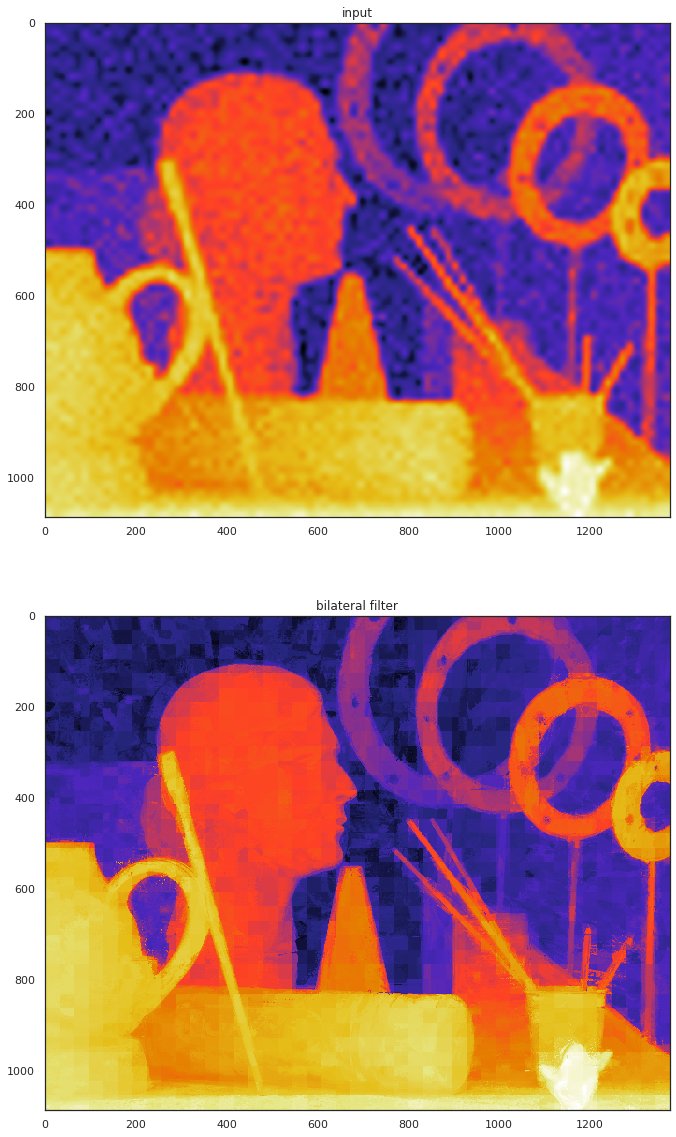

In [34]:
figure(figsize=(14, 20))
subplot(211)
imshow(target)
title('input')
subplot(212)
imshow(output)
title('bilateral filter')